# This notebook illustrates advantages of using prior weights

In [1]:
using Revise
using MendelIHT
using SnpArrays
using DataFrames
using Distributions
using BenchmarkTools
using Random
using LinearAlgebra
using GLM

In [22]:
function compare(n::Int, p::Int, k::Int, d::UnionAll, l::Link)
    # construct snpmatrix, covariate files, and true model b
    x, = simulate_random_snparray(n, p, "tmp.bed")
    xbm = SnpBitMatrix{Float64}(x, model=ADDITIVE_MODEL, center=true, scale=true); 
    z = ones(n, 1) # the intercept
    
    # simulate response, true model b, and the correct non-0 positions of b
    y, true_b, correct_position = simulate_random_response(x, xbm, k, d, l)

    #add correlation to the predictors
    adhoc_add_correlation(x, 0.9, 5000, 4, 10)

    
    # construct weight vector
    w = ones(p)
    w[correct_position] .= 2.0
    one_tenth = round(Int, p/10)
    idx = rand(1:p, one_tenth)
    w[idx] .= 2.0 #randomly set ~1/10 of all predictors to 2 to be "a bit more fair"

    #run IHT
    unweighted = L0_reg(x, xbm, z, y, 1, k, d(), l, debias=false, init=false, use_maf=false)
    weighted   = L0_reg(x, xbm, z, y, 1, k, d(), l, debias=false, init=false, use_maf=false, weight=w)

    #check result
    compare_model = DataFrame(
        position    = correct_position,
        correct     = true_b[correct_position],
        unweighted  = unweighted.beta[correct_position], 
        weighted    = weighted.beta[correct_position])
    @show compare_model
    println("\n")

    #clean up
    rm("tmp.bed", force=true)
    
    unweighted_found = count(!iszero, unweighted.beta[correct_position])
    weighted_found = count(!iszero, weighted.beta[correct_position])
    return unweighted_found, weighted_found
end

compare (generic function with 2 methods)

In [23]:
function run(d::UnionAll, l::Link)
    #simulat data with k true predictors, from distribution d and with link l.
    n = 1000
    p = 10000
    k = 10

    unweighted_found = 0
    weighted_found = 0
    for i in 1:50
        uf, wf = compare(n, p, k, d, l)
        unweighted_found += uf
        weighted_found += wf
    end
    println("\n")
    println(string(d) * ": unweighted IHT found $unweighted_found")
    println(string(d) * ": weighted IHT found $weighted_found")
    println("\n")
end

run (generic function with 1 method)

In [24]:
Random.seed!(2019)

pairs = [(Normal, IdentityLink()), 
         (Bernoulli, LogitLink()),
         (Poisson, LogLink()),
         (NegativeBinomial, LogLink())]
for pair in pairs
    run(pair[1], pair[2])
end

compare_model = 10×4 DataFrame
│ Row │ position │ correct  │ unweighted │ weighted  │
│     │ Int64    │ Float64  │ Float64    │ Float64   │
├─────┼──────────┼──────────┼────────────┼───────────┤
│ 1   │ 853      │ -1.29964 │ -1.24117   │ -1.24118  │
│ 2   │ 877      │ -0.2177  │ -0.234677  │ -0.234676 │
│ 3   │ 924      │ 0.786217 │ 0.82014    │ 0.820147  │
│ 4   │ 2703     │ 0.599233 │ 0.583406   │ 0.583388  │
│ 5   │ 4241     │ 0.283711 │ 0.298299   │ 0.298289  │
│ 6   │ 4783     │ -1.12537 │ -1.14459   │ -1.14459  │
│ 7   │ 5094     │ 0.693374 │ 0.673006   │ 0.672995  │
│ 8   │ 5284     │ -0.67709 │ -0.709735  │ -0.709733 │
│ 9   │ 7760     │ 0.14727  │ 0.16866    │ 0.168648  │
│ 10  │ 8255     │ 1.03477  │ 1.08116    │ 1.08118   │


compare_model = 10×4 DataFrame
│ Row │ position │ correct   │ unweighted │ weighted  │
│     │ Int64    │ Float64   │ Float64    │ Float64   │
├─────┼──────────┼───────────┼────────────┼───────────┤
│ 1   │ 1446     │ -0.116317 │ 0.0        │ -0.115417

In [43]:
using Plots

names = ["Normal unweighted", "Normal weighted", "Bernoulli unweighted", "Bernoulli weighted",
         "Poisson unweighted", "Poisson weighted", "NB unweighted", "NB weighted"]
found = [443, 448, 353, 373, 360, 385, 286, 318]
bar(names, found);

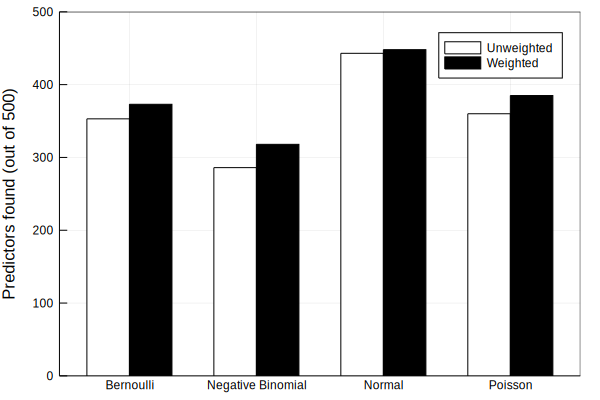

In [84]:
using StatsPlots

found = [443 448; 353 373; 360 385; 286 318]
category = repeat(["Unweighted", "Weighted"], inner = 4)
name = repeat(["Normal", "Bernoulli", "Poisson", "Negative Binomial"], outer = 2)
bar_color = [:white, :white, :white, :white, :black, :black, :black, :black, ]

groupedbar(name, found, group = category, ylabel = "Predictors found (out of 500)",
        bar_width = 0.67, color = bar_color,
        lw = 1, framestyle = :box, ylim = (0, 500))


In [88]:
hi = groupedbar(name, found, group = category, ylabel = "Predictors found (out of 500)",
        bar_width = 0.67, color = bar_color, dpi = 300,
        lw = 1, framestyle = :box, ylim = (0, 500))
StatsPlots.savefig(hi, "weight_plot")